### Prototyping the Analysis Pipeline for the [Stroke Risk Prediction]

# !!Note!! If "Shap" does not work use "!pip install shap" or without "!" to install it first

In [179]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
import shap

# Dataset preperation
Uploading the csv file to prepare for 

In [180]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.to_csv("healthcare-dataset-stroke-data.csv", index=False)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

Changeing the feature names for clarity and refinement for the users

In [181]:
df = df.rename(columns={
                          "id":"ID",
                          "gender": "Sex",
                          "age": "Age",
                          "hypertension": "Hypertension",
                          "heart_disease": "Heart Disease",
                          "ever_married": "Married",
                          "work_type": "Work Type",
                          "Residence_type": "Residence Type",
                          "avg_glucose_level": "Glucose",
                          "bmi": "BMI",
                          "smoking_status": "Smoking?",
                          "stroke": "Stroke"
                          })
df.head(10)

ID     Sex   Age  Hypertension  Heart Disease Married      Work Type  \
0   9046    Male  67.0             0              1     Yes        Private   
1  51676  Female  61.0             0              0     Yes  Self-employed   
2  31112    Male  80.0             0              1     Yes        Private   
3  60182  Female  49.0             0              0     Yes        Private   
4   1665  Female  79.0             1              0     Yes  Self-employed   
5  56669    Male  81.0             0              0     Yes        Private   
6  53882    Male  74.0             1              1     Yes        Private   
7  10434  Female  69.0             0              0      No        Private   
8  27419  Female  59.0             0              0     Yes        Private   
9  60491  Female  78.0             0              0     Yes        Private   

  Residence Type  Glucose   BMI         Smoking?  Stroke  
0          Urban   228.69  36.6  formerly smoked       1  
1          Rural   202.21   NaN     never smoked       1  
2          Rural   105.92  32.5     never smoked       1  
3          Urban   171.23  34.4           smokes       1  
4          Rural   174.12  24.0     never smoked       1  
5          Urban   186.21  29.0  formerly smoked       1  
6          Rural    70.09  27.4     never smoked       1  
7          Urban    94.39  22.8     never smoked       1  
8          Rural    76.15   NaN          Unknown       1  
9          Urban    58.57  24.2          Unknown       1

Checking the data types of the dataset

In [182]:
print(df.dtypes)

ID                  int64
Sex                object
Age               float64
Hypertension        int64
Heart Disease       int64
Married            object
Work Type          object
Residence Type     object
Glucose           float64
BMI               float64
Smoking?           object
Stroke              int64
dtype: object


Certain datatypes are not valid or correct, all the "object" datatypes needs to be changed. First I grouped the features that i believe should be a certain datatype and then I convert them.

In [183]:
bool_cols = ["Hypertension", "Heart Disease", "Married", "Stroke"]
categorical_cols = ["Sex", "Residence Type", "Smoking?", "Work Type"]
numeric_cols = ["Age"]
string_cols = ["ID"]

df[bool_cols] = df[bool_cols].astype(bool)
df[categorical_cols] = df[categorical_cols].apply(lambda x: pd.Categorical(x))
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
df[string_cols] = df[string_cols].astype(str)

print(df.dtypes)

ID                  object
Sex               category
Age                float64
Hypertension          bool
Heart Disease         bool
Married               bool
Work Type         category
Residence Type    category
Glucose            float64
BMI                float64
Smoking?          category
Stroke                bool
dtype: object


Checking the dataset if there are any missing values in every feature.

In [184]:
df.isnull().sum()

ID                  0
Sex                 0
Age                 0
Hypertension        0
Heart Disease       0
Married             0
Work Type           0
Residence Type      0
Glucose             0
BMI               201
Smoking?            0
Stroke              0
dtype: int64

Luckely, only "BMI" had missing values, changeing these values to 0 instead to make them still count.

In [185]:
df["BMI"] = df["BMI"].fillna(0)
df.isnull().sum()

ID                0
Sex               0
Age               0
Hypertension      0
Heart Disease     0
Married           0
Work Type         0
Residence Type    0
Glucose           0
BMI               0
Smoking?          0
Stroke            0
dtype: int64

Create a new file for the processed data

In [186]:
df.to_csv('processed_data.csv', index=False)
print(df.columns)
row_count = df.shape[0]

Index(['ID', 'Sex', 'Age', 'Hypertension', 'Heart Disease', 'Married',
       'Work Type', 'Residence Type', 'Glucose', 'BMI', 'Smoking?', 'Stroke'],
      dtype='object')


In [187]:
# Define target (y) and features (x)
y = df['Stroke']
X = df.drop(columns=['Stroke']) #All features except "Stroke"

ID                  0
Sex                 0
Age                 0
Hypertension        0
Heart Disease       0
Married             0
Work Type           0
Residence Type      0
Glucose             0
BMI               201
Smoking?            0
Stroke              0
dtype: int64

In [188]:
#Importing models for training

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Gradientboosting was the chosen from "scikit" it is quick and works well with large datasets. 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [189]:
from sklearn.model_selection import train_test_split

#Splitting the training- and testdata with a stratified partitioning (0.2 = 20%, which means the testset is 20% and the trainingset is 80%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
df_train_example = pd.concat([X_train, y_train], axis=1)

In [190]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#List of categorical features for one-hotencoding process
categorical_features = ['Sex', 'Work Type', 'Residence Type', 'Smoking?']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

#Transform the data
X_encoded = preprocessor.fit_transform(df)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

#Dataframe with onehot encoding
df_encoded = pd.get_dummies(df, columns=['Sex', 'Work Type', 'Residence Type', 'Smoking?'], drop_first=True)

#Dividing feature and target
X = df_encoded.drop(columns='Stroke')
y = df_encoded['Stroke']

#Train/test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on training data
X_test_scaled = scaler.transform(X_test)


#We are able to change the parameters below to try to find the result we want
models = {
    "DT": DecisionTreeClassifier(max_depth=8, class_weight='balanced'), 
    "RF": RandomForestClassifier(n_estimators=10, max_depth=5, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "SVM": SVC(kernel='rbf', class_weight='balanced'),
    "NB": GaussianNB(),
    "HGB": HistGradientBoostingClassifier(max_iter=100),
    "LR": LogisticRegression(solver='liblinear', max_iter=1000)
}

#Training the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} accuracy: {accuracy_score(y_test, y_pred):.2f}")


DT accuracy: 0.81
RF accuracy: 0.79
KNN accuracy: 0.94
SVM accuracy: 0.50
NB accuracy: 0.93
HGB accuracy: 0.94
LR accuracy: 0.93


In [192]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import time

#Creating an empty "Panda" dataframe
results = pd.DataFrame({
                        "classifier_name": [],
                        "training_time": [],
                        "prediction_time": [],
                        "accuracy": [],
                        "precision": [],
                        "recall": [],
                        "f1": []
                        })
results

#Define the evaluation metrics to be returned by the cross-validation
scoring_metrics = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0)
} 

#This is where I apply classifiers in each dataset
for name, classifier in models.items():

    #This is where the cross-validation happens
    results_eval_dt = cross_validate(classifier, X_train, y_train, cv=5, scoring=scoring_metrics)

    #This goes through each classifer, starts and stops the time and stores it in "training_time"
    t_start = time.time()
    classifier.fit(X_train,y_train)
    t_end = time.time()
    training_time = t_end - t_start

    #This is where the prediction happens, starts and stops the time and stores the results in "prediction_time"
    t_start = time.time()
    y_predicted = classifier.predict(X_test)
    t_end = time.time()
    prediction_time = t_end - t_start

    #These lines give the performance metrics asked
    accuracy_result = accuracy_score(y_test, y_predicted)
    precision_result = precision_score(y_test, y_predicted, zero_division=0)
    recall_result = recall_score(y_test, y_predicted, zero_division=0)
    f1_result = f1_score(y_test, y_predicted, zero_division=0)

    #Puts the results in their "headlines"
    this_result = pd.DataFrame({
        "classifier_name": [name],
        "training_time": [results_eval_dt['fit_time'].mean()],
        "prediction_time": [results_eval_dt['score_time'].mean()],
        "accuracy": [results_eval_dt['test_accuracy'].mean()],
        "precision": [results_eval_dt['test_precision_macro'].mean()],
        "recall": [results_eval_dt['test_recall_macro'].mean()],
        "f1": [results_eval_dt['test_f1_macro'].mean()]
    })

    #Prints the results
    results = pd.concat([results, this_result], axis=0, ignore_index=True)
results.head(10)

classifier_name  training_time  prediction_time  accuracy  precision  \
0              DT       0.013054         0.008688  0.791345   0.549916   
1              RF       0.028394         0.009140  0.771534   0.560744   
2             KNN       0.003199         0.046292  0.954257   0.477128   
3             SVM       0.416845         0.194962  0.597378   0.497083   
4              NB       0.003604         0.007794  0.927103   0.574313   
5             HGB       0.267042         0.013095  0.948141   0.608033   
6              LR       0.012001         0.008000  0.949363   0.603450   

     recall        f1  
0  0.692132  0.542039  
1  0.760496  0.548388  
2  0.500000  0.488296  
3  0.483207  0.400200  
4  0.567022  0.569957  
5  0.522327  0.530800  
6  0.541062  0.553053

--------------------------------------------------------------------------------------------------------------------

# Take advantage of jupyter notebooks from previous courses! (DSHI?😉)

---

### Example of a simple pre-trained model from Scikit-learn

Training a logistic regression here, that can be loaded to make predictions on user input on the web dashboard.

Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html


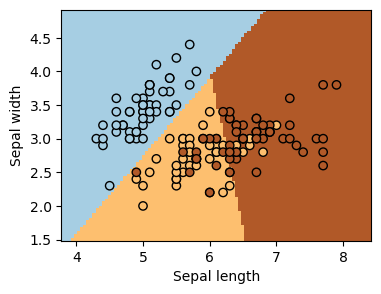

In [193]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

_, ax = plt.subplots(figsize=(4, 3))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Sepal length",
    ylabel="Sepal width",
    eps=0.5,
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)
plt.show()

## Exporting a pretrained model

In the dashboard, you should load a pre-trained model that was designed and evaluated in the jupyter notebook. You can do it with `pickle` or any alternative for the same purpose.

In [194]:
import pickle

In [195]:
# Save in the `assets` folder so that it is accessible from the web dashboard
file_path = "../assets/trained_model.pickle"
data_to_save = logreg

# Creates a binary object and writes the indicated variables
with open(file_path, "wb") as writeFile:
    pickle.dump(data_to_save, writeFile)

In [196]:
# Load model
pre_trained_model_path = "../assets/trained_model.pickle"
loaded_model = None # This will be replaced by the trained model in the pickle 

with open(pre_trained_model_path, "rb") as readFile:
    loaded_model = pickle.load(readFile)

In [197]:
loaded_model

LogisticRegression(C=100000.0)

In [198]:
# Sepal [length, width]
user_data = [[5, 4]] # Must be 2D array
prediction = loaded_model.predict(user_data)

print(f"The predicted value for data {user_data} is {prediction}")

The predicted value for data [[5, 4]] is [0]
